In [1]:
from fastai import *
from fastai.vision import *

%matplotlib inline

In [2]:
PATH = os.path.abspath('..')

sys.path.append(f'{PATH}/src')
from mxresnet import *
from ranger import Ranger

Mish activation loaded...
Mish activation loaded...


In [3]:
seed = 12345

In [4]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv')

tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1., max_rotate=15., max_lighting=0, max_warp=0)

xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]


bs = 32
sz = 224

In [5]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2, seed=seed)
                .label_from_df(cols=['logfgas'],  label_cls=FloatList)
      )

data = (src.transform(tfms, size=sz)
            .databunch(bs=bs)
            .normalize(xGASS_stats)
       )

In [6]:
learn = Learner(data, model=mxresnet50(), 
                opt_func=partial(Ranger),
                loss_func=root_mean_squared_error,
                wd=1e-3, bn_wd=False, true_wd=True,
               )

learn.model[-1] = nn.Linear(2048, 1, bias=True)


In [21]:
learn.load('mxresnet50-ranger_100ep');

set state called


In [22]:
learn.data.valid_dl.batch_size = 32

In [ ]:
fgas_pred, fgas_true = learn.TTA()

In [14]:
root_mean_squared_error(fgas_pred, fgas_true)

tensor(0.2410)

In [13]:
results = pd.DataFrame({'fgas_pred': fgas_pred.squeeze(), 'fgas_true': fgas_true.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

results.sample(3)

,fgas_pred,fgas_true
AGCNr,,
258422,0.714514,0.987363
202649,0.209043,-0.218964
251098,-0.105456,-0.178010


In [15]:
results.to_csv(f'{PATH}/results/predictions/best_a40-50.csv')

In [26]:
results['d_fgas'] = results.fgas_pred - results.fgas_true

results.index = results.index.astype(np.int64)

# Crossmatch with other data

In [11]:
results = pd.read_csv(f'{PATH}/results/predictions/best_a40A-50.csv')
results['d_fgas'] = results.fgas_pred - results.fgas_true


In [17]:
data = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv', index_col='AGCNr')
redshifts = pd.read_csv(f'{PATH}/data/a40.datafile3.csv', index_col='AGCNr', usecols=('AGCNr', 'z_sdss'))
density = pd.read_csv(f'{PATH}/data/a.40-delta_5.csv', index_col='AGCNr', usecols=('AGCNr', 'delta_5'))

In [24]:
df = results.join(data, on='AGCNr', how='left').join(redshifts, on='AGCNr', how='left').join(density, on='AGCNr', how='left')
df.dropna(inplace=True)
df.sample(3)

,AGCNr,fgas_pred,fgas_true,d_fgas,Unnamed: 0,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas,logsSFR,z_sdss,delta_5
1084,224408,0.490000,0.334972,0.155028,6132.0,5.877328e+17,8.93,8.595028,-0.927108,8.616266,0.334972,-9.522136,0.01967,0.662121
567,211210,0.700478,0.328952,0.371526,5029.0,5.877416e+17,9.77,9.441048,-0.199880,8.871527,0.328952,-9.640928,0.03321,2.729562
230,210260,-0.277128,-0.403500,0.126372,4860.0,5.877422e+17,9.47,9.873500,0.215204,9.146879,-0.403500,-9.658296,0.02277,3.017168


In [25]:
df.shape

(983, 14)

# Plot altogether

In [26]:
display(np.corrcoef(df.logMstar, df.d_fgas)[0,1])
display(np.corrcoef(df.logSFR, df.d_fgas)[0,1])
display(np.corrcoef(df.Zgas, df.d_fgas)[0,1])
display(np.corrcoef(df[df.delta_5.notna()].delta_5, df[df.delta_5.notna()].d_fgas)[0,1])

0.12346950929144593

-0.07502869197597661

0.03655018645531365

0.019206157950663036

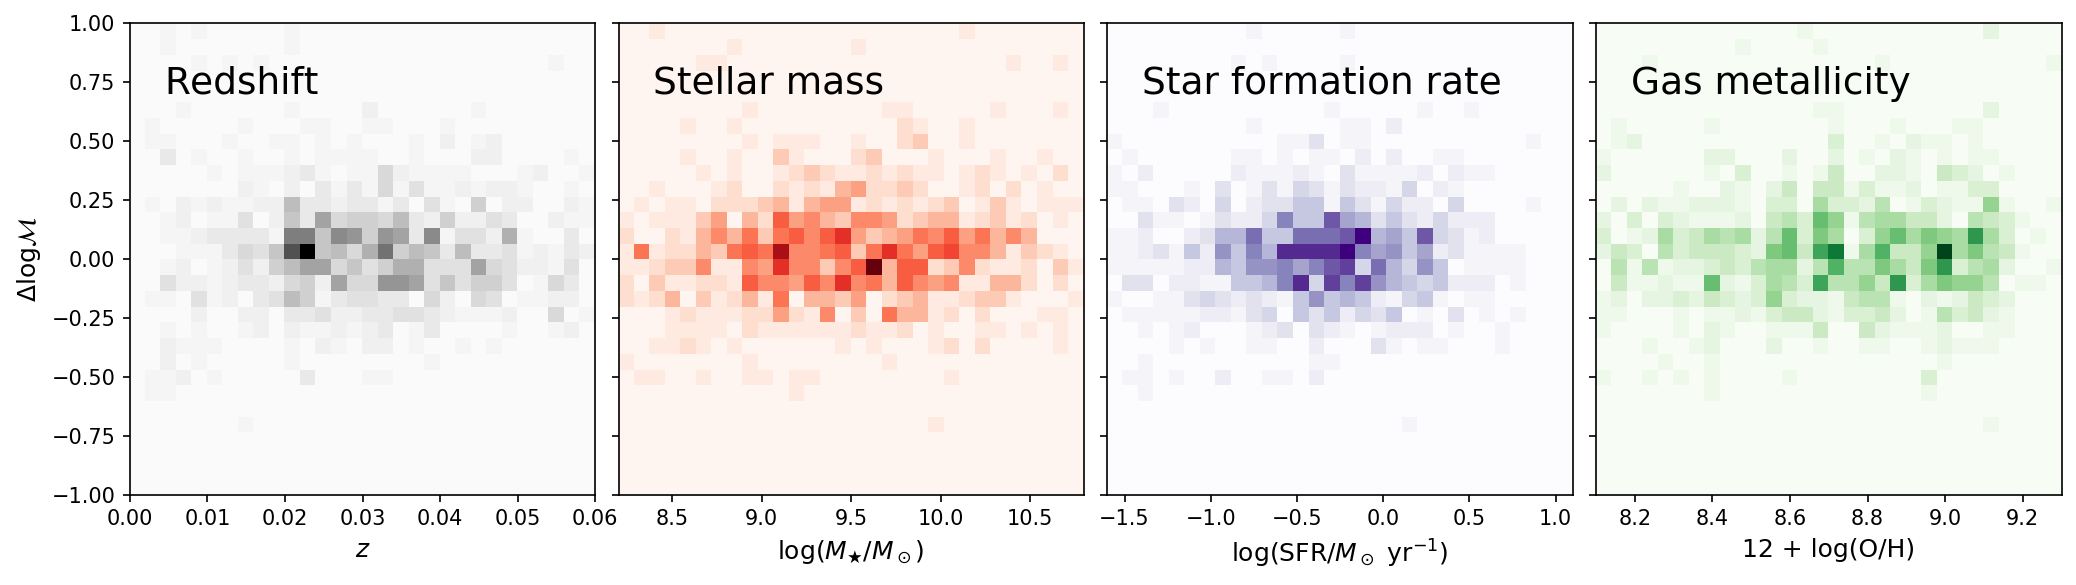

In [64]:

fig, [ax0, ax1, ax2, ax3] = plt.subplots(1, 4, figsize=(14, 4), dpi=150, sharey=True)

ax0.hist2d(df.z_sdss, df.d_fgas, cmap='Greys', bins=30, range=[(0, 0.06), (-1, 1)], vmin=-1);
ax0.text(0.075, 0.85, r'Redshift', fontsize=18, transform=ax0.transAxes)
ax0.set_xlabel(r'$z$', fontsize=12)
ax0.set_ylabel(r'$\Delta \log \mathcal{M}$', fontsize=12)

ax1.hist2d(df.logMstar, df.d_fgas, cmap='Reds', bins=30, range=[(8.2, 10.8), (-1, 1)]);
ax1.text(0.075, 0.85, r'Stellar mass', fontsize=18, transform=ax1.transAxes)
ax1.set_xlabel(r'$\log(M_★/M_\odot)$', fontsize=12)

ax2.hist2d(df.logSFR, df.d_fgas, cmap='Purples', bins=30, range=[(-1.6, 1.1), (-1, 1)]);
ax2.text(0.075, 0.85, r'Star formation rate', fontsize=18, transform=ax2.transAxes)
ax2.set_xlabel(r'log(SFR/$M_\odot~{\rm yr}^{-1})$', fontsize=12)

ax3.hist2d(df.Zgas, df.d_fgas, cmap='Greens', bins=30, range=[(8.1, 9.3), (-1, 1)]);
ax3.text(0.075, 0.85, r'Gas metallicity', fontsize=18, transform=ax3.transAxes)
ax3.set_xlabel(r'12 + log(O/H)', fontsize=12)

fig.tight_layout()
fig.subplots_adjust(wspace=0.05)

fig.savefig(f'{PATH}/results/figures/physical-trends.png')

# Check for correlations

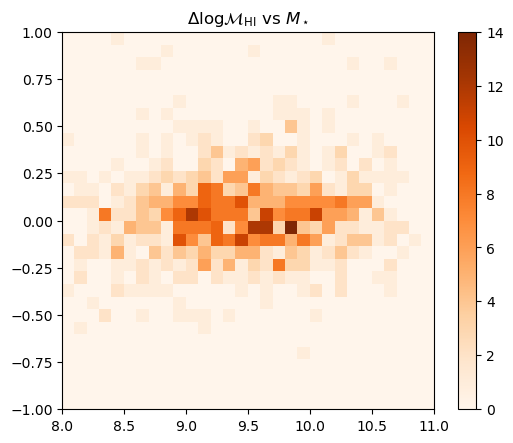

In [38]:
plt.figure(figsize=(6, 5), dpi=100)
plt.title(r'$\Delta \log\mathcal{M}_{\rm HI}$ vs $M_\star$')
plt.hist2d(df.logMstar, df.d_fgas, cmap='Oranges', bins=30, range=[(8, 11), (-1, 1)]);
plt.colorbar()

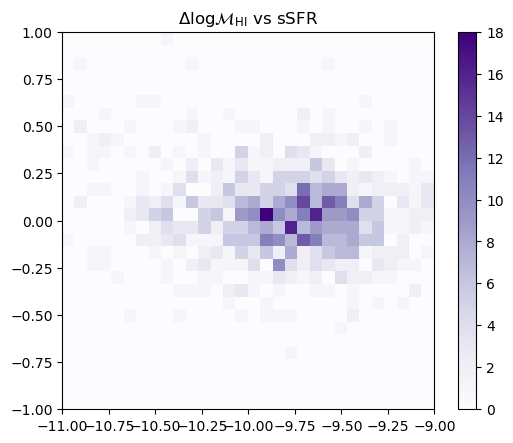

In [39]:
plt.figure(figsize=(6, 5), dpi=100)
plt.title(r'$\Delta \log\mathcal{M}_{\rm HI}$ vs sSFR')
plt.hist2d(df.logsSFR, df.d_fgas, cmap='Purples', bins=30, range=[(-11, -9), (-1, 1)]);
plt.colorbar()

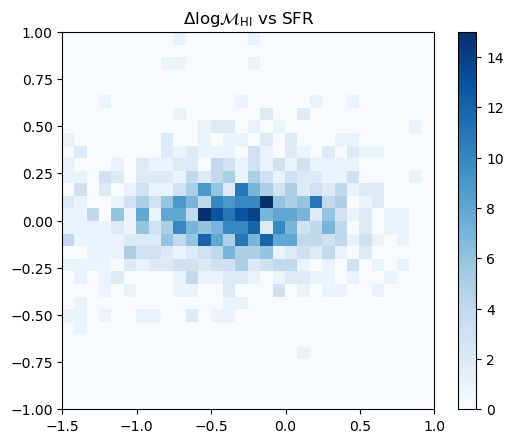

In [40]:
plt.figure(figsize=(6, 5), dpi=100)
plt.title(r'$\Delta \log\mathcal{M}_{\rm HI}$ vs SFR')
plt.hist2d(df.logSFR, df.d_fgas, cmap='Blues', bins=30, range=[(-1.5, 1), (-1, 1)]);
plt.colorbar()

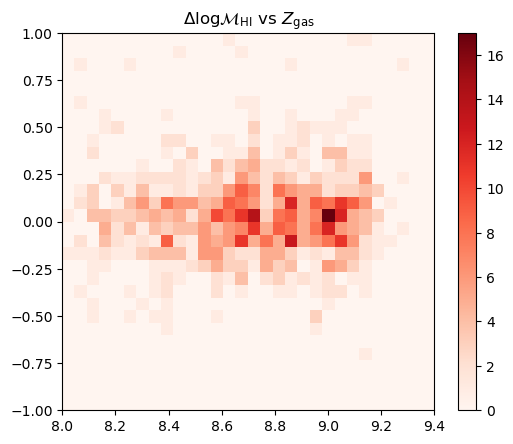

In [41]:
plt.figure(figsize=(6, 5), dpi=100)
plt.title(r'$\Delta \log\mathcal{M}_{\rm HI}$ vs $Z_{\rm gas}$')
plt.hist2d(df.Zgas, df.d_fgas, cmap='Reds', bins=30, range=[(8.0, 9.4), (-1, 1)]);
plt.colorbar()

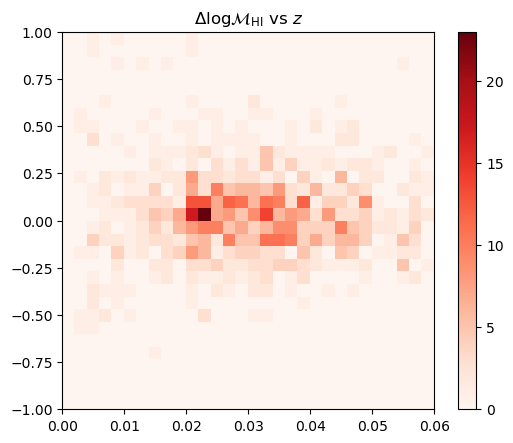

In [42]:
plt.figure(figsize=(6, 5), dpi=100)
plt.title(r'$\Delta \log\mathcal{M}_{\rm HI}$ vs $z$')
plt.hist2d(df.z_sdss, df.d_fgas, cmap='Reds', bins=30, range=[(0, 0.06), (-1, 1)]);
plt.colorbar()

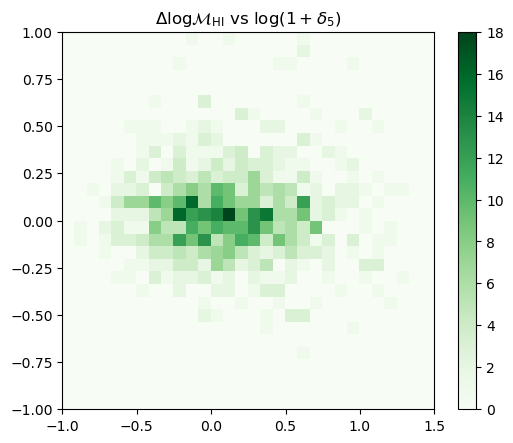

In [44]:
plt.figure(figsize=(6, 5), dpi=100)
plt.title(r'$\Delta \log\mathcal{M}_{\rm HI}$ vs $\log (1 + \delta_5)$')
plt.hist2d(np.log10(df.delta_5), df.d_fgas, cmap='Greens', bins=30, range=[(-1., 1.5), (-1, 1)]);
plt.colorbar()